In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import math
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler #para escalar caracteristicas
from sklearn.model_selection import train_test_split # separar mas facil la data de train y test

# Activation Functions
En resumidas cuentas es una aplicar una transformacionNO lineal a la SALIDA de una capa y basicamente decidir si el "neuron" debe activarse o no.
¿Por que se usa?
Si no usaramos funciones de activacion, solo podriamos tener transformaciones lineales sobre otras transformaciones lineales lineales, transformando el modelo solo en una transformación lineal, el cual no es muy adecuado para tareas complejas. Por tanto es necesario para algunos problemas (la mayoria) aplicar ciertas funciones no lineales.

## Funciones de activaciones mas comunes
1. Step function (aunque se usa poco en la practica)
2. Sigmoid (usado por ejemplo en regresion logistica, en problemas de clasificacion binaria (ultima capa))
3. Tanh (similar a sigmoid, buena opcion dentro de capas ocultas)
4. ReLU (opcion más popular en la mayoria de las redes, muy util, si no se sabe que usar es la mejor opción por defecto)
5. Leaky ReLU (version levemente medificada de ReLU. Usado si se quiere resolver el problema de "desaparición de gradiente", esto es cuando la gradiente es extremadamente cercano a cero y los pesos no aprenden nada. Si los pesos no se actualizan es buena opción utilizar esto en vez de ReLU normal)
6. Softmax (Bueno para la ultima capa en un problema de multiclasificación)


# Feed Foward Net

## Device config

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Esto garantiza que se ejecutara en GPU si esta disponible
print(device)

cpu


## Hyperparametros

In [3]:
input_size = 784 # Esto es porque las imagenes de entrada son 28x28 => un tensor de tamaño de entrada 784
hidden_size = 10000
num_classes = 10 # Ya que hay 10 diferentes clases
num_epochs = 5
batch_size = 100
learning_rate = 0.001

## MNIST Data

torch.Size([100, 1, 28, 28]) torch.Size([100])


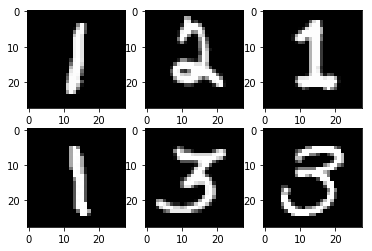

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          transform =transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform =transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                          shuffle=False) #Aqui no es importante el shuffle
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)
for i in range(6):
    plt.subplot(2,3,i+1) #2 rows 3 columns
    plt.imshow(samples[i][0], cmap='gray')

    
plt.show()

In [10]:
print(test_loader)

In [5]:
print("Tamaño de la muestra:")
print("Numero de muestras en el lote: ",samples.shape[0])
print("Canales: ",samples.shape[1])
print("Filas: ",samples.shape[2])
print("Columnas: ",samples.shape[3])

Tamaño de la muestra:
Numero de muestras en el lote:  100
Canales:  1
Filas:  28
Columnas:  28


## Full Neuronal Network
Queremos clasificar estos digitos, para esto haremos una red neuronal completamente conectada

In [6]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        # Aquí creamos las capas con sus respectivas funciones de activacion
        self.l1 = nn.Linear(input_size, hidden_size) # Capa/Layer 1
        self.relu = nn.ReLU() # Se aplica funcion de activacion ReLu
        self.l2 = nn.Linear(hidden_size, num_classes) # Capa2, 
        #observar que ahora la entrada tendra tamaño hidden_size
        # mientras que la salida tendra tamaño del número de clases, 
        # eso indica que es nuestra última capa
        # Teoricamente vendria el softmax pero no se aplicara ya que se hara entropia cruzada y recordar que
        # esta la aplica AUTOMATICAMENTE,, por ende PARA ESTE CASO
        # NO ES NECESARIA APLICAR LA FUNCIÓN DE ACTIVACIÓN SOFTMAX
        
    # Se aplica el modelo construido arriba en el forward    
    def forward(self,x):
        out=self.l1(x)
        out=self.relu(out)
        out=self.l2(out)
        # OJO cuidado que aquí no quiero aplicar nuevamente la función de activacion como se explico arriba
        return out
        
# Definimos el modelo con la clase
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
    

## Loss y optimizer

In [7]:
criterion = nn.CrossEntropyLoss() # De paso aplica la funcion softmax por nosotros
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # Se usara el optimizador ADAM

## Training Loop

In [8]:
n_total_step = len(train_loader) 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Aplicar reshape
        # Las imaenes estan 100,1,28,28 (el 100 solo especifica cantidad, y el 1 numero de canales lo cual solo es relevante en CNN))
        # Volverlos un tensor de entrada 100, 784
        images = images.reshape(-1, 28*28) #Se envia el GPU si esta disponible...
        labels = labels.to(device)
        # forward
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
    
        # backwar
        loss.backward()
        optimizer.step()
        
        # Vaciar los grads
        optimizer.zero_grad()
        
        # Print progreso
        if (i+1)%100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_step}, loss = {loss.item():.4f}')

            
        


epoch 1/5, step 100/600, loss = 0.1577
epoch 1/5, step 200/600, loss = 0.4576
epoch 1/5, step 300/600, loss = 0.1385
epoch 1/5, step 400/600, loss = 0.1497
epoch 1/5, step 500/600, loss = 0.0519
epoch 1/5, step 600/600, loss = 0.0665
epoch 2/5, step 100/600, loss = 0.1131
epoch 2/5, step 200/600, loss = 0.0278
epoch 2/5, step 300/600, loss = 0.0050
epoch 2/5, step 400/600, loss = 0.0654
epoch 2/5, step 500/600, loss = 0.1458
epoch 2/5, step 600/600, loss = 0.0791
epoch 3/5, step 100/600, loss = 0.0817
epoch 3/5, step 200/600, loss = 0.0200
epoch 3/5, step 300/600, loss = 0.0569
epoch 3/5, step 400/600, loss = 0.0289
epoch 3/5, step 500/600, loss = 0.0810
epoch 3/5, step 600/600, loss = 0.0618
epoch 4/5, step 100/600, loss = 0.0275
epoch 4/5, step 200/600, loss = 0.0165
epoch 4/5, step 300/600, loss = 0.0256
epoch 4/5, step 400/600, loss = 0.0300
epoch 4/5, step 500/600, loss = 0.1547
epoch 4/5, step 600/600, loss = 0.0050
epoch 5/5, step 100/600, loss = 0.0016
epoch 5/5, step 200/600, 

## Testing evaluation

In [9]:
# SIEMPRE EVITAR CONSIDERAR LOS GRADIENTES
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # Debemos hacer nuevamente el reshape OJO
        images = images.reshape(-1, 28*28).to(device) #Se envia el GPU si esta disponible...
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1) # obtener el max posible valor
        n_samples += labels.shape[0] # numero de muestras por lote actual
        n_correct += (predictions == labels).sum().item() #ver cuantas acertaron, si acerto suma 1 si no 0
    # Medir % precision
    acc = 100.0 * n_correct/n_samples
    
    print(f'accuracy = {acc}')
        
        

accuracy = 97.63
